In [1]:
# Importing packages

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Image loading and preprocessing, the function return a preprocessed image tensor
def load_and_preprocess_image(image_path):

    #img=tf.strings.as_string(image_path)
    img=tf.io.read_file(image_path)

    #Decode the JPEG image to a tensor
    img=tf.image.decode_jpeg(img)

    #Normalize pixel values to the range [0, 1]
    img=img/255

    #Resize the image to a fixed size (64x64 pixels)
    img=tf.image.resize(img, [64,64])

    #Convert the image tensor to float32 data type
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

# This function loads and preprocesses a label from the given label_path
def load_and_preprocess_label(label_path):
    # Read the label file as a string
    label=tf.io.read_file(label_path)

    # Convert the string label to a numerical value
    label=tf.strings.to_number(label)

    # Normalize the label
    label=label/1000

    #Convert the label tensor to float32 data type
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


window_size = 120  # Define the window size
stride = 136 

y=[]
for ds in tf.data.Dataset.list_files("test_seq/*/labels/*", shuffle=False).map(load_and_preprocess_label).window(16, shift=136, drop_remainder=True).take(2205):
    for element in ds:
        #print(element.numpy())
        y.append(element.numpy())
    #print("Move")

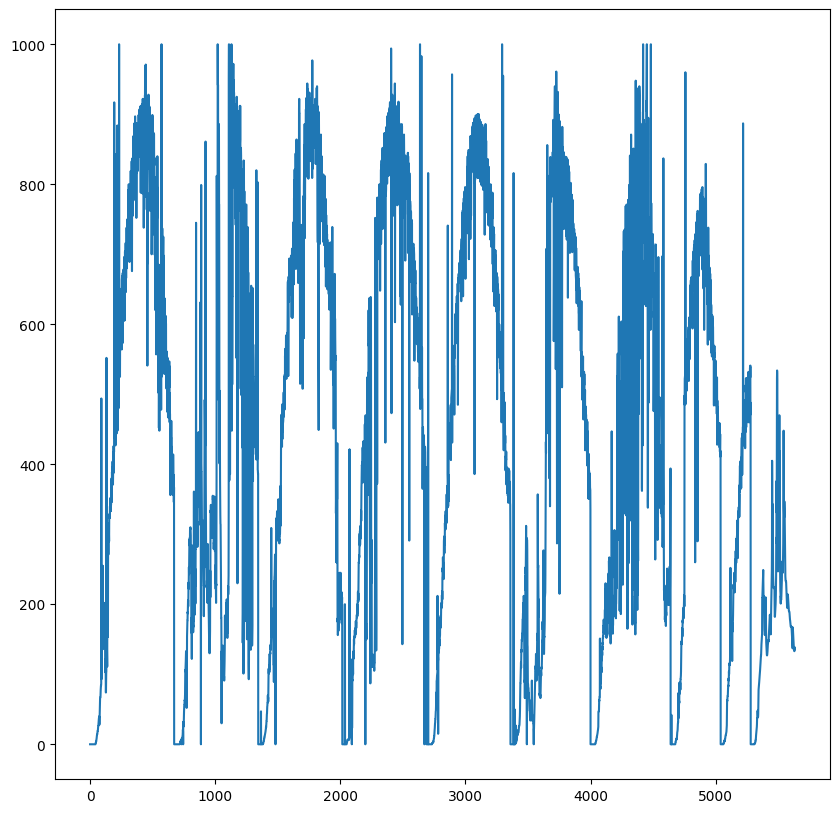

In [58]:
plt.plot(y)

**Building data pipeline**

In [2]:
def load_and_preprocess_image(image_path):
    img=tf.io.read_file(image_path)
    img=tf.image.decode_jpeg(img)
    img=img/255
    img=tf.image.resize(img, [64,64])
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

def load_and_preprocess_label(label_path):
    label=tf.io.read_file(label_path)
    label=tf.strings.to_number(label)
    label=label/1000
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


window_size = 120  # Define the window size
stride = 136 

#Pipeline construction for validation image sequences
val_img_dataset=tf.data.Dataset.list_files("val_data_seq/*/images/*", shuffle=False)
val_img_dataset=val_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_img_dataset=val_img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
val_img_dataset=val_img_dataset.batch(16).cache('val_cache_img_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for validation label sequences
val_label_dataset=tf.data.Dataset.list_files("val_data_seq/*/labels/*", shuffle=False)
val_label_dataset=val_label_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(window_size, shift=stride, drop_remainder=True)
val_label_dataset=val_label_dataset.flat_map(lambda x: x.batch(window_size))
val_label_dataset=val_label_dataset.batch(16).cache('val_cache_lbl_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for validation target sequences
val_forecast_dataset=tf.data.Dataset.list_files("val_data_seq/*/labels/*", shuffle=False).skip(120)
val_forecast_dataset=val_forecast_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(16, shift=stride, drop_remainder=True)
val_forecast_dataset=val_forecast_dataset.flat_map(lambda x: x.batch(16))
val_forecast_dataset=val_forecast_dataset.batch(16).cache('val_cache_forecast_folderr_2').prefetch(tf.data.AUTOTUNE)


#Pipeline construction for train image sequences
img_dataset=tf.data.Dataset.list_files("data_seq/*/images/*", shuffle=False)
img_dataset=img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
img_dataset=img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
img_dataset=img_dataset.batch(16).cache('cache_img_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for train label sequences
label_dataset=tf.data.Dataset.list_files("data_seq/*/labels/*", shuffle=False)
label_dataset=label_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(window_size, shift=stride, drop_remainder=True)
label_dataset=label_dataset.flat_map(lambda x: x.batch(window_size))
label_dataset=label_dataset.batch(16).cache('cache_lbl_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for train target sequences
forecast_dataset=tf.data.Dataset.list_files("data_seq/*/labels/*", shuffle=False).skip(120)
forecast_dataset=forecast_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(16, shift=stride, drop_remainder=True)
forecast_dataset=forecast_dataset.flat_map(lambda x: x.batch(16))
forecast_dataset=forecast_dataset.batch(16).cache('cache_forecast_folderr_2').prefetch(tf.data.AUTOTUNE)


'for sequences_dataset in img_dataset.take(1):\n    print(sequences_dataset.shape)\n    print("ok")'

In [ ]:
# Define the window size and stride for dataset processing
window_size = 120 
stride = 136  # Stride for moving the window

# Create a dataset for loading and preprocessing test images
test_img_dataset = tf.data.Dataset.list_files("test_seq/*/images/*", shuffle=False)
test_img_dataset = test_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Divide the dataset into non-overlapping windows of specified window_size with a specified stride
test_img_dataset = test_img_dataset.window(window_size, shift=stride, drop_remainder=True)

# Flatten the nested windows to form a single sequence of images
test_img_dataset = test_img_dataset.flat_map(lambda x: x.batch(window_size))

# Batch the images (group them into batches of size 8)
test_img_dataset = test_img_dataset.batch(8)

# Cache the dataset in memory for faster retrieval
test_img_dataset = test_img_dataset.cache('test_cache_img_folder')

# Prefetch the data to optimize loading
test_img_dataset = test_img_dataset.prefetch(tf.data.AUTOTUNE)

# Create a dataset for loading and preprocessing test labels
test_label_dataset = tf.data.Dataset.list_files("test_seq/*/labels/*", shuffle=False)
test_label_dataset = test_label_dataset.map(load_and_preprocess_label)
test_label_dataset = test_label_dataset.window(window_size, shift=stride, drop_remainder=True)
test_label_dataset = test_label_dataset.flat_map(lambda x: x.batch(window_size))
test_label_dataset = test_label_dataset.batch(8)
test_label_dataset = test_label_dataset.cache('test_cache_lbl_folder')

# Prefetch the data to optimize loading
test_label_dataset = test_label_dataset.prefetch(tf.data.AUTOTUNE)


In [2]:
model=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\using CONV2D + LSTM\Forecast 1.8M param LSTM.h5")
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed_144 (TimeDist  (None, 120, 62, 62,  1792       ['input_37[0][0]']               
 ributed)                        64)                                                              
                                                                                                  
 time_distributed_145 (TimeDist  (None, 120, 31, 31,  0          ['time_distributed_144[0][0]']   
 ributed)                        64)                                                       

# **1- Model 1**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Image processing network
image_input = tf.keras.layers.Input(shape=(120, 64, 64, 3))
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))(cnn_output)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))(cnn_output)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(cnn_output)
cnn_output = tf.keras.layers.LSTM(32)(cnn_output)

# Time series forecasting network
label_input = tf.keras.layers.Input(shape=(120,1))
inn=LSTM(128, return_sequences=True)(label_input)

inn=LSTM(128, return_sequences=True)(inn)

inn=LSTM(64)(inn)

# Concatenate the outputs of the two networks
concatenated = tf.keras.layers.concatenate([cnn_output, inn])

# Additional dense layers for prediction
x = Dense(256, activation='relu')(concatenated)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)

x = Dense(32, activation='relu')(x)

output = Dense(16)(x)

# Create the model
model_1 = tf.keras.Model(inputs=[image_input, label_input], outputs=output)

model_1.summary()


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed_144 (TimeDist  (None, 120, 62, 62,  1792       ['input_37[0][0]']               
 ributed)                        64)                                                              
                                                                                                  
 time_distributed_145 (TimeDist  (None, 120, 31, 31,  0          ['time_distributed_144[0][0]']   
 ributed)                        64)                                                       

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast_1_8",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)


num_epochs = 1000

train_data= tf.data.Dataset.zip((img_dataset, label_dataset))
train_data_2=tf.data.Dataset.zip((train_data, forecast_dataset))

val_data= tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_data_2=tf.data.Dataset.zip((val_data, val_forecast_dataset))


model_1.fit(train_data_2, validation_data=val_data_2, epochs=num_epochs, callbacks=my_callbacks, verbose=1)

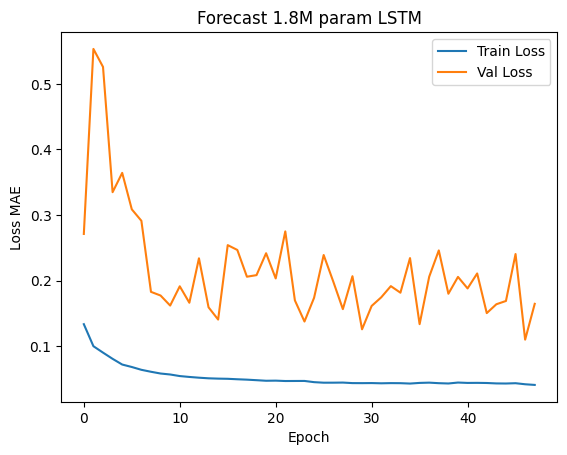

In [32]:
loss=model_1.history.history['loss']
val_loss=model_1.history.history['val_loss']

plt.plot(loss[1:], label='Train Loss')
plt.plot(val_loss[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Forecast 1.8M param LSTM')
plt.show()

In [34]:
model_1.save("Forecast 1.8M param LSTM.h5")

# 2- **Model 2**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Image processing network
image_input = tf.keras.layers.Input(shape=(120, 64, 64, 3))
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(cnn_output)
cnn_output = tf.keras.layers.LSTM(16)(cnn_output)

# Time series forecasting network
label_input = tf.keras.layers.Input(shape=(120,1))
rnn_output = tf.keras.layers.LSTM(256,return_sequences=True)(label_input)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)

rnn_output = tf.keras.layers.LSTM(64,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(64)(rnn_output)

# Concatenate the outputs of the two networks
concatenated = tf.keras.layers.concatenate([cnn_output, rnn_output])

# Additional dense layers for prediction
x = tf.keras.layers.Dense(256, activation='relu')(concatenated)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

output = tf.keras.layers.Dense(16)(x)

# Create the model
model_2 = tf.keras.Model(inputs=[image_input, label_input], outputs=output)

model_2.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 120, 1)]     0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 lstm_87 (LSTM)                 (None, 120, 256)     264192      ['input_36[0][0]']               
                                                                                                  
 time_distributed_113 (TimeDist  (None, 120, 62, 62,  896        ['input_35[0][0]']        

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)

# Training loop
num_epochs = 20

train_data= tf.data.Dataset.zip((img_dataset, label_dataset))
train_data_2=tf.data.Dataset.zip((train_data, forecast_dataset))

val_data= tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_data_2=tf.data.Dataset.zip((val_data, val_forecast_dataset))


model_2.fit(train_data_2, validation_data=val_data_2, epochs=num_epochs, verbose=1)

Epoch 1/20
261/261 [==============================] - 4342s 17s/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.1400 - val_mean_absolute_error: 0.1400
Epoch 2/20
261/261 [==============================] - 153s 585ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0952 - val_mean_absolute_error: 0.0952
Epoch 3/20
261/261 [==============================] - 93s 355ms/step - loss: 0.0559 - mean_absolute_error: 0.0559 - val_loss: 0.0930 - val_mean_absolute_error: 0.0930
Epoch 4/20
261/261 [==============================] - 93s 355ms/step - loss: 0.0529 - mean_absolute_error: 0.0529 - val_loss: 0.0989 - val_mean_absolute_error: 0.0989
Epoch 5/20
261/261 [==============================] - 93s 357ms/step - loss: 0.0533 - mean_absolute_error: 0.0533 - val_loss: 0.0958 - val_mean_absolute_error: 0.0958
Epoch 6/20
261/261 [==============================] - 93s 357ms/step - loss: 0.0518 - mean_absolute_error: 0.0518 - val_loss: 0.1011 - val_mean_absolute_error: 0.10

In [ ]:
model_2.fit(train_data_2, validation_data=val_data_2, epochs=50, verbose=1)

Epoch 1/50
261/261 [==============================] - 92s 353ms/step - loss: 0.0436 - mean_absolute_error: 0.0436 - val_loss: 0.0635 - val_mean_absolute_error: 0.0635
Epoch 2/50
261/261 [==============================] - 93s 354ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - val_loss: 0.0665 - val_mean_absolute_error: 0.0665
Epoch 3/50
261/261 [==============================] - 93s 354ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.0613 - val_mean_absolute_error: 0.0613
Epoch 4/50
261/261 [==============================] - 92s 354ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0720 - val_mean_absolute_error: 0.0720
Epoch 5/50
261/261 [==============================] - 92s 354ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - val_loss: 0.0657 - val_mean_absolute_error: 0.0657
Epoch 6/50
261/261 [==============================] - 93s 354ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0643 - val_mean_absolute_error: 0.064

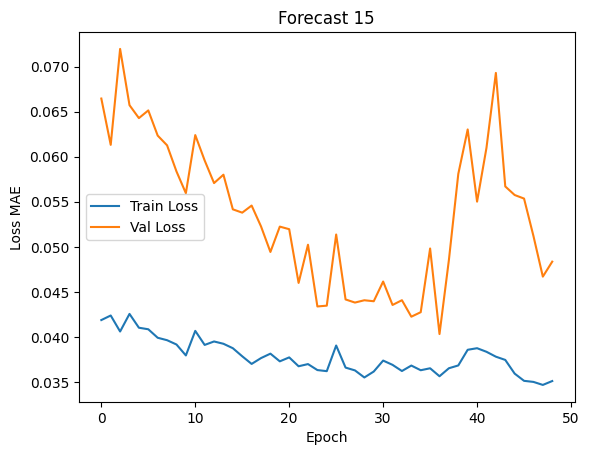

In [ ]:
loss=model_2.history.history['loss']
val_loss=model_2.history.history['val_loss']

plt.plot(loss[1:], label='Train Loss')
plt.plot(val_loss[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Forecast 15')
plt.show()

# 3- **Model 3**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Image processing network
image_input = tf.keras.layers.Input(shape=(120, 64, 64, 3))
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)


cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(cnn_output)
cnn_output = tf.keras.layers.LSTM(16)(cnn_output)

# Time series forecasting network
label_input = tf.keras.layers.Input(shape=(120,1))
rnn_output = tf.keras.layers.LSTM(256,return_sequences=True)(label_input)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)

#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(64)(rnn_output)

# Concatenate the outputs of the two networks
concatenated = tf.keras.layers.concatenate([cnn_output, rnn_output])

# Additional dense layers for prediction
x = tf.keras.layers.Dense(256, activation='relu')(concatenated)

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)

output = tf.keras.layers.Dense(16)(x)

# Create the model
model_3 = tf.keras.Model(inputs=[image_input, label_input], outputs=output)

model_3.summary()


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_56 (InputLayer)          [(None, 120, 1)]     0           []                               
                                                                                                  
 time_distributed_173 (TimeDist  (None, 120, 62, 62,  1792       ['input_55[0][0]']               
 ributed)                        64)                                                              
                                                                                           

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast",'model4M.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)

# Training loop
num_epochs = 150

train_data= tf.data.Dataset.zip((img_dataset, label_dataset))
train_data_2=tf.data.Dataset.zip((train_data, forecast_dataset))

val_data= tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_data_2=tf.data.Dataset.zip((val_data, val_forecast_dataset))


model_3.fit(train_data_2, validation_data=val_data_2, epochs=num_epochs, verbose=1)

Epoch 1/150
261/261 [==============================] - 108s 412ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0795 - val_mean_absolute_error: 0.0795
Epoch 2/150
261/261 [==============================] - 108s 412ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0801 - val_mean_absolute_error: 0.0801
Epoch 3/150
261/261 [==============================] - 108s 412ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0820 - val_mean_absolute_error: 0.0820
Epoch 4/150
261/261 [==============================] - 108s 412ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0827 - val_mean_absolute_error: 0.0827
Epoch 5/150
261/261 [==============================] - 107s 410ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0844 - val_mean_absolute_error: 0.0844
Epoch 6/150
261/261 [==============================] - 107s 410ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0848 - val_mean_absolute_

KeyboardInterrupt: 

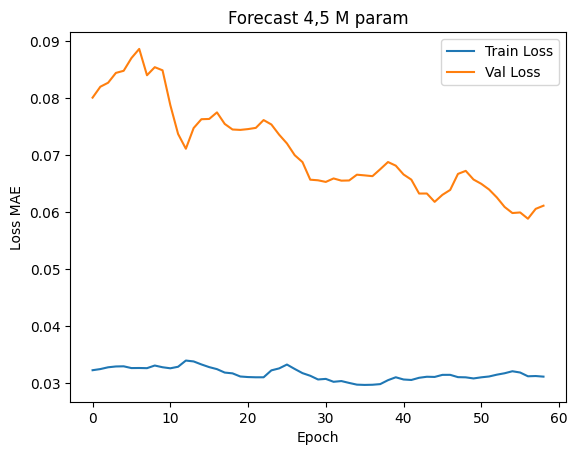

In [ ]:
loss=model_3.history.history['loss']
val_loss=model_3.history.history['val_loss']

plt.plot(loss[1:], label='Train Loss')
plt.plot(val_loss[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Forecast 4,5 M param')
plt.show()

In [ ]:
val_loss_0

[0.08074556291103363,
 0.08568308502435684,
 0.08583379536867142,
 0.0906028151512146,
 0.09126953035593033,
 0.09317480027675629,
 0.09617716073989868,
 0.09873941540718079,
 0.10278335958719254,
 0.10541893541812897,
 0.10791013389825821,
 0.11002226918935776,
 0.11075358837842941,
 0.10976791381835938,
 0.10926531255245209,
 0.10784026980400085,
 0.10252683609724045,
 0.0928252711892128,
 0.08758348226547241,
 0.08285308629274368,
 0.07894766330718994,
 0.07620725780725479,
 0.07420959323644638,
 0.07311361283063889,
 0.07312075793743134,
 0.07206390798091888,
 0.07199817150831223,
 0.07022817432880402,
 0.0676983892917633,
 0.06664633005857468,
 0.06599118560552597,
 0.06418300420045853,
 0.06395193934440613,
 0.06252845376729965,
 0.06405450403690338,
 0.061778828501701355,
 0.060488563030958176,
 0.059752218425273895,
 0.05868342146277428,
 0.05769088491797447,
 0.05780484527349472,
 0.056902285665273666,
 0.05704810097813606,
 0.057169109582901,
 0.05740225315093994,
 0.05974912

**I trained the model twice. Here are the losses added in one graph** 

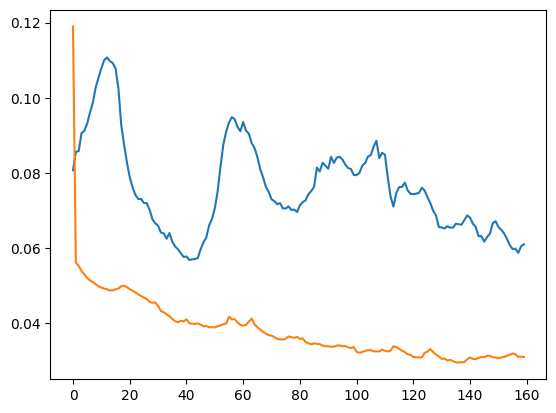

In [ ]:
plt.plot(val_loss_0+val_loss)
plt.plot(loss_0+loss)

In [ ]:
model_3.save("forecast.4.5M param.h5")

# **4-Model 4**


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Image processing network
image_input = tf.keras.layers.Input(shape=(120, 64, 64, 3))
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))(cnn_output)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(cnn_output)
cnn_output = tf.keras.layers.LSTM(64)(cnn_output)

# Time series forecasting network
label_input = tf.keras.layers.Input(shape=(120,1))
rnn_output = tf.keras.layers.LSTM(256,return_sequences=True)(label_input)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(64)(rnn_output)

# Concatenate the outputs of the two networks
concatenated = tf.keras.layers.concatenate([cnn_output, rnn_output])

# Additional dense layers for prediction
# Additional dense layers for prediction
x = Dense(256, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(16)(x)

# Create the model
model_4 = tf.keras.Model(inputs=[image_input, label_input], outputs=output)

model_4.summary()



# Create the model
model_4 = Model(inputs=[image_input, label_input], outputs=output)

model_4.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed_71 (TimeDistr  (None, 120, 62, 62,  1792       ['input_19[0][0]']               
 ibuted)                         64)                                                              
                                                                                                  
 time_distributed_72 (TimeDistr  (None, 120, 31, 31,  0          ['time_distributed_71[0][0]']    
 ibuted)                         64)                                                        

In [17]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast_lastweek",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)


num_epochs = 1000

train_data= tf.data.Dataset.zip((img_dataset, label_dataset))
train_data_2=tf.data.Dataset.zip((train_data, forecast_dataset))

val_data= tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_data_2=tf.data.Dataset.zip((val_data, val_forecast_dataset))


model_4.fit(train_data_2, validation_data=val_data_2, epochs=num_epochs, callbacks=my_callbacks, verbose=1)

Epoch 1/1000
261/261 [==============================] - 155s 594ms/step - loss: 0.2814 - mean_absolute_error: 0.2814 - val_loss: 0.2424 - val_mean_absolute_error: 0.2424
Epoch 2/1000
261/261 [==============================] - 156s 596ms/step - loss: 0.2462 - mean_absolute_error: 0.2462 - val_loss: 0.3339 - val_mean_absolute_error: 0.3339
Epoch 3/1000
261/261 [==============================] - 156s 599ms/step - loss: 0.2230 - mean_absolute_error: 0.2230 - val_loss: 0.2611 - val_mean_absolute_error: 0.2611
Epoch 4/1000
261/261 [==============================] - 150s 575ms/step - loss: 0.2064 - mean_absolute_error: 0.2064 - val_loss: 0.1355 - val_mean_absolute_error: 0.1355
Epoch 5/1000
261/261 [==============================] - 146s 561ms/step - loss: 0.1935 - mean_absolute_error: 0.1935 - val_loss: 0.2345 - val_mean_absolute_error: 0.2345
Epoch 6/1000
261/261 [==============================] - 144s 551ms/step - loss: 0.1791 - mean_absolute_error: 0.1791 - val_loss: 0.1732 - val_mean_abs

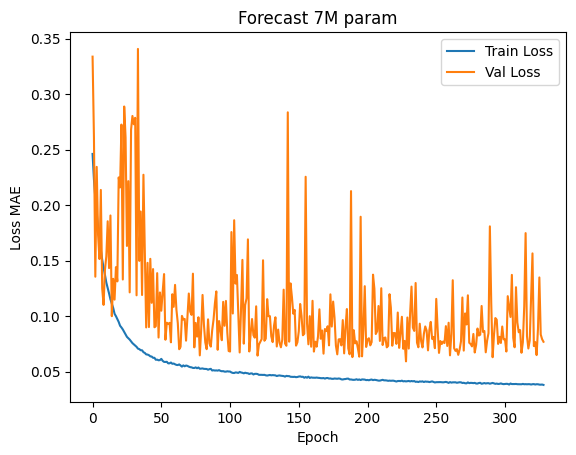

In [19]:
loss=model_4.history.history['loss']
val_loss=model_4.history.history['val_loss']

plt.plot(loss[1:], label='Train Loss')
plt.plot(val_loss[1:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Forecast 7M param')
plt.show()

In [111]:
window_size = 120  # Define the window size
stride = 136

test_img_dataset=tf.data.Dataset.list_files("test_on_train_data_seq/*/images/*", shuffle=False)
test_img_dataset=test_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_img_dataset=test_img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
test_img_dataset=test_img_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_label_dataset=tf.data.Dataset.list_files("test_on_train_data_seq/*/labels/*", shuffle=False)
test_label_dataset=test_label_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(window_size, shift=stride, drop_remainder=True)
test_label_dataset=test_label_dataset.flat_map(lambda x: x.batch(window_size))
test_label_dataset=test_label_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_forecast_dataset=tf.data.Dataset.list_files("test_on_train_data_seq/*/labels/*", shuffle=False)
test_forecast_dataset=test_forecast_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(16, shift=stride, drop_remainder=True)
test_forecast_dataset=test_forecast_dataset.flat_map(lambda x: x.batch(16))
test_forecast_dataset=test_forecast_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [110]:
len(os.listdir("test_on_train_data_seq\\2021-06-27_9\\images"))

136

In [12]:
for element in test_img_dataset.take(2):
    print(element.shape)

(16, 120, 64, 64, 3)


In [46]:
window_size = 120  # Define the window size
stride = 136
testi_dataset=tf.data.Dataset.list_files("test_on_train_data_seq/*/images/*", shuffle=False).window(window_size, shift=stride, drop_remainder=True)
for ds in testi_dataset.take(2):
    print(len(list(ds)))
    

120
120


In [84]:
for element in test_img_dataset.take(3):
    print(element.shape)

(16, 120, 64, 64, 3)
(16, 120, 64, 64, 3)
(10, 120, 64, 64, 3)


In [112]:

test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))


y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

1/1 [==============================] - 0s 292ms/step


In [115]:
yz=np.array(y_hat).reshape(-1)*1000

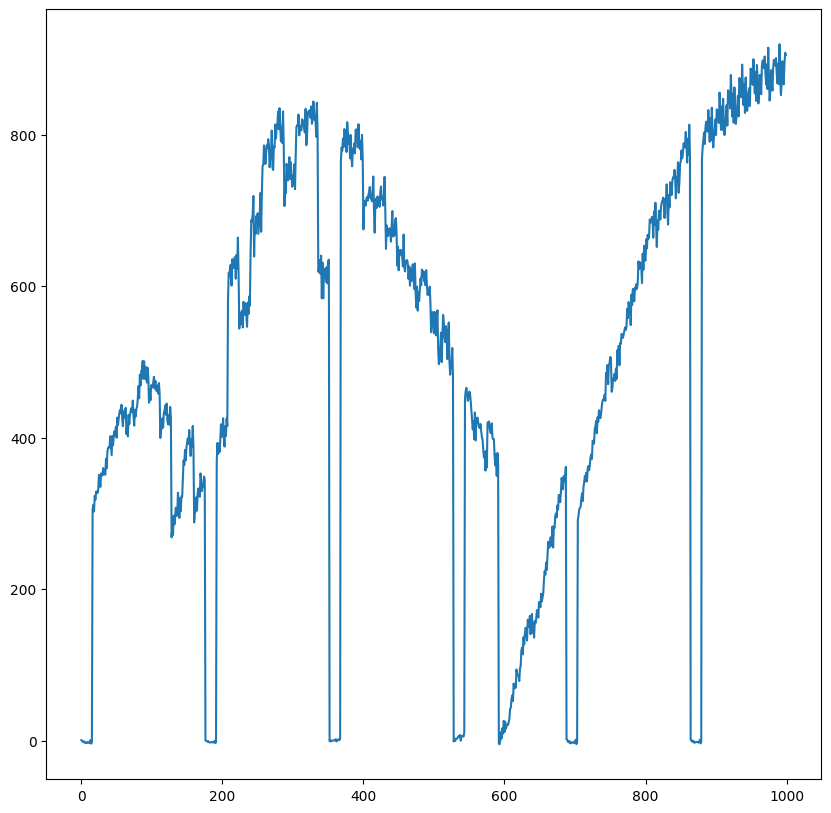

In [120]:
plt.figure(figsize=(10,10))
plt.plot(yz[:1000])

In [67]:

for element in test_data.take(3):
    print(element[0][1].shape)
    print(element[0][0].shape)

AttributeError: 'tuple' object has no attribute 'take'

In [56]:
print(len((1,2,3,4,5)))

5


In [83]:

for element in train_data_2.take(3):
    print(element[0][0].shape)

(16, 120, 64, 64, 3)
(16, 120, 64, 64, 3)
(16, 120, 64, 64, 3)


In [36]:
yho=y_hat.reshape(-1)

In [31]:
yho*1000

array([-6.8232417e-02, -1.3402236e-01, -1.3422775e+00, -1.1002389e+00,
       -6.1320347e-01, -1.6192403e+00, -1.9547744e+00, -1.6229209e+00,
       -2.0626714e+00, -6.8362427e-01, -2.1588945e+00, -1.8366575e+00,
       -1.7109541e+00,  9.5454323e-01, -2.4022982e+00, -6.9918299e-01,
        8.5410199e+02,  8.6683612e+02,  8.9717859e+02,  8.7371753e+02,
        8.6528766e+02,  8.9623126e+02,  9.0833575e+02,  9.0785651e+02,
        9.0348944e+02,  9.0535083e+02,  8.8271674e+02,  8.7548322e+02,
        8.9708124e+02,  8.7186633e+02,  9.2615332e+02,  8.8439374e+02,
        8.2761554e+02,  8.4231787e+02,  8.6040765e+02,  8.4299316e+02,
        8.3892590e+02,  8.5786798e+02,  8.7677185e+02,  8.7495526e+02,
        8.6535468e+02,  8.6756476e+02,  8.4200598e+02,  8.4056775e+02,
        8.6075378e+02,  8.3792664e+02,  8.8445245e+02,  8.5113806e+02,
        7.7219299e+02,  8.0048645e+02,  8.0152313e+02,  7.7547760e+02,
        7.8886005e+02,  7.6860583e+02,  8.0646069e+02,  7.8459747e+02,
      

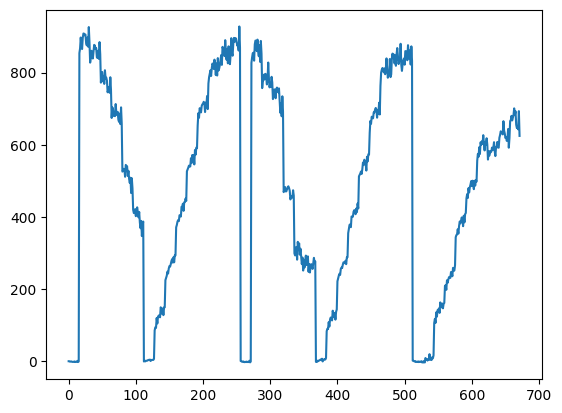

In [37]:
plt.plot(yho*1000)

<AxesSubplot:xlabel='Time'>

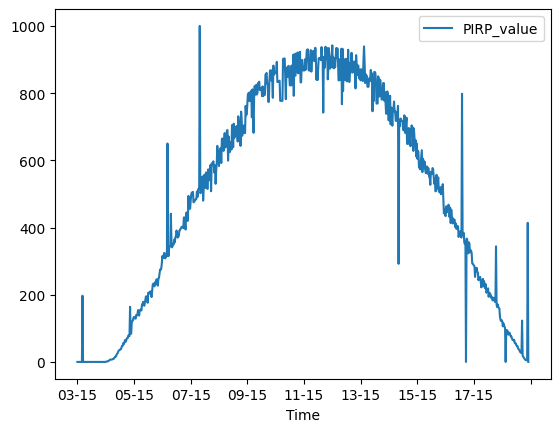

In [14]:
csv_dir=os.path.join("preprocess_csv_files_new","2021-06-25.csv")
data=pd.read_csv(csv_dir,delimiter=';', error_bad_lines=False)
data.plot(x="Time",y="PIRP_value")

In [347]:
def load_and_preprocess_image(image_path):
    # Implement your image loading and preprocessing logic here
    # This function should return a preprocessed image tensor
    img=tf.io.read_file(image_path)
    img=tf.image.decode_jpeg(img)
    img=img/255
    img=tf.image.resize(img, [64,64])
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

def load_and_preprocess_label(label_path):
    # Implement your label loading and preprocessing logic here
    # This function should return a preprocessed label tensor

    label=tf.io.read_file(label_path)
    label=tf.strings.to_number(label)
    label=label/1000
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


def process_sequence(file_path):
    
    print(file_path)
    image_folder_path = tf.strings.join([file_path, "images", "*"],separator="\\")
    label_folder_path = tf.strings.join([file_path, "labels", "*"],separator="\\")
    #print(image_folder_path)
    print('ok',image_folder_path)
    
    image_dataset = tf.data.Dataset.list_files(image_folder_path, shuffle=False)
    #print(list(image_dataset))
    image_dataset = list(image_dataset.map(load_and_preprocess_image))
    #print(list(image_dataset))
    print("before img 1")
    input_sequence = image_dataset[:120]
    print("after img 1")
    
    # Load and process the labels
    label_dataset = tf.data.Dataset.list_files(label_folder_path, shuffle=False)
    label_dataset = list(label_dataset.map(load_and_preprocess_label))
    print("debut label")
    
    label_sequence = label_dataset[:120]
    print("after label")
    
    
    forecast_labels = label_dataset[120:]
    
    return input_sequence



In [348]:
for el in tf.data.Dataset.list_files("data_seq/*", shuffle=False).take(1):
    print(el)

tf.Tensor(b'data_seq\\2021-06-25_0', shape=(), dtype=string)


In [349]:
def mapping_func_tf(filepath):
    
    inp_img, inp_label, out_label = tf.py_function(func=process_sequence, inp=[filepath], Tout=(tf.float32, tf.float32, tf.float32))
    inp_img.set_shape((120, 64, 64, 3))
    inp_label.set_shape((120,))
    out_label.set_shape((16,))

    print("inp_img shape:", inp_img.shape)
    print("inp_label shape:", inp_label.shape)
    print("out_label shape:", out_label.shape)
    print("inp_img type:", inp_img.dtype)
    print("inp_label type:", inp_label.dtype)
    print("out_label type:", out_label.dtype)
    
    return (inp_img, inp_label), out_label


In [350]:
batch_size=4 # car bcp d'image deja 8*120...

train_ds=tf.data.Dataset.list_files("test_seq/*", shuffle=False)
train_ds = train_ds.map(process_sequence, num_parallel_calls=tf.data.AUTOTUNE)#.map(return_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#input_sequences, label_sequences, forecast_labels = zip(*train_ds)



Tensor("args_0:0", shape=(), dtype=string)
ok Tensor("StringJoin:0", shape=(), dtype=string)


KeyError: 'IteratorGetNext_1437505'

In [301]:
for ds in train_ds:
    print(type(ds))

<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'>


KeyboardInterrupt: 

In [ ]:
batch_size = 2

# Iterate over the dataset in batches and convert elements to tensors
tensor_batches = []
for batch in train_ds.batch(batch_size):
    tensor_elements = [tf.convert_to_tensor(element, dtype=tf.float32) for element in batch.as_numpy_iterator()]
    tensor_batches.append(tensor_elements)

# Process the tensor batches and feed them into the model

In [217]:
for ds in train_ds.take(5):
    print(ds)

<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>


In [219]:
for ds in train_ds.batch(2).take(5):
    print(ds)

tensor_batches = []
for batch in train_ds.take(3):
    tensor_elements = [tf.convert_to_tensor(element, dtype=tf.float32) for element in batch.as_numpy_iterator()]
    tensor_batches.append(tensor_elements)
print(tensor_batches)

[[<tf.Tensor: shape=(120, 64, 64, 3), dtype=float32, numpy=
array([[[[0.8901961 , 0.8901961 , 0.8901961 ],
         [0.00980392, 0.00980392, 0.00980392],
         [0.47941178, 0.47941178, 0.47941178],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        

In [302]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Image processing network
image_input = tf.keras.layers.Input(shape=(120, 64, 64, 3))
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))(cnn_output)
cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(cnn_output)

cnn_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(cnn_output)
cnn_output = tf.keras.layers.LSTM(64)(cnn_output)

# Time series forecasting network
label_input = tf.keras.layers.Input(shape=(120,1))
rnn_output = tf.keras.layers.LSTM(256,return_sequences=True)(label_input)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(128,return_sequences=True)(rnn_output)
#rnn_output=tf.keras.layers.Dropout(0.2)
rnn_output = tf.keras.layers.LSTM(64)(rnn_output)

# Concatenate the outputs of the two networks
concatenated = tf.keras.layers.concatenate([cnn_output, rnn_output])

# Additional dense layers for prediction
x = tf.keras.layers.Dense(256, activation='relu')(concatenated)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(16)(x)

# Create the model
model = tf.keras.Model(inputs=[image_input, label_input], outputs=output)

model.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed_115 (TimeDist  (None, 120, 62, 62,  896        ['input_48[0][0]']               
 ributed)                        32)                                                              
                                                                                                  
 time_distributed_116 (TimeDist  (None, 120, 31, 31,  0          ['time_distributed_115[0][0]']   
 ributed)                        32)                                                       

In [6]:
def preprocess_data_input(input_sequence,label_sequence, forecast_label):
    
    return  input_sequence,label_sequence

def preprocess_data_forecast(input_sequence,label_sequence, forecast_label):
    
    return  forecast_label

train_ds_input = train_ds.map(preprocess_data_input)
train_ds_forecast=train_ds.map(preprocess_data_forecast)

train_ds_input = train_ds_input.map(lambda x, y: (tf.convert_to_tensor(x), tf.convert_to_tensor(y)))
train_ds_forecast = train_ds_forecast.map(tf.convert_to_tensor)

combined_dataset = tf.data.Dataset.zip((train_ds_input, train_ds_forecast))




TypeError: in user code:

    File "C:\Users\saad\AppData\Local\Temp\ipykernel_12232\2846678505.py", line 12, in None  *
        lambda x, y: (tf.convert_to_tensor(x), tf.convert_to_tensor(y)))

    TypeError: Failed to convert elements of <tensorflow.python.data.ops.dataset_ops._NestedVariant object at 0x0000028293352A90> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


In [172]:
for element in train_ds_input.take(1):
    flattened_element = tf.nest.flatten(element)
    for item in flattened_element:
        print(item)

<_VariantDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None)>


In [153]:
print(train_img_seq)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [303]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)

# Training loop
num_epochs=700

model.fit(x=[train_img_seq,train_label_seq],y=train_forecast_seq, epochs=num_epochs,callbacks=my_callbacks,verbose=1)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>", "<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>"}), <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>

In [129]:
train_ds

<PrefetchDataset element_spec=(DatasetSpec((TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)), TensorShape([None])), DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorShape([None])))>

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(
    x=[img_seq_tf_data, label_seq_tf_data],
    y=forecast_label_15,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

In [ ]:
model=tf.keras.models.load_model("forecast_model.h5")
test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))

y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

1/1 [==============================] - 0s 121ms/step


In [ ]:
yz=np.array(y_hat).reshape(-1)*1000

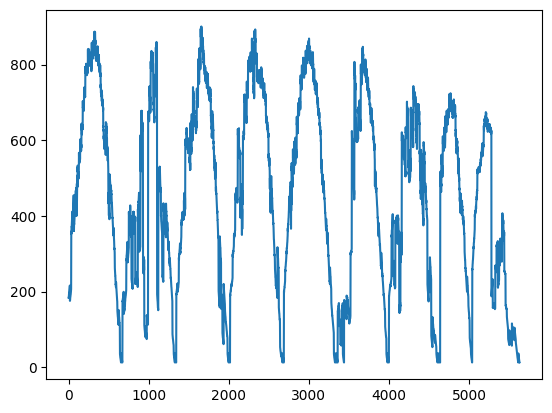

'\ny_actual=np.array(y)*1000\nplt.figure(figsize=(10,10))\nplt.plot(y_actual[120+4000:6000],label="Actual")\nplt.plot(yz[4000:6000-136],label="Predicted")\nplt.legend()\nplt.title("model.forecast_7M param")'

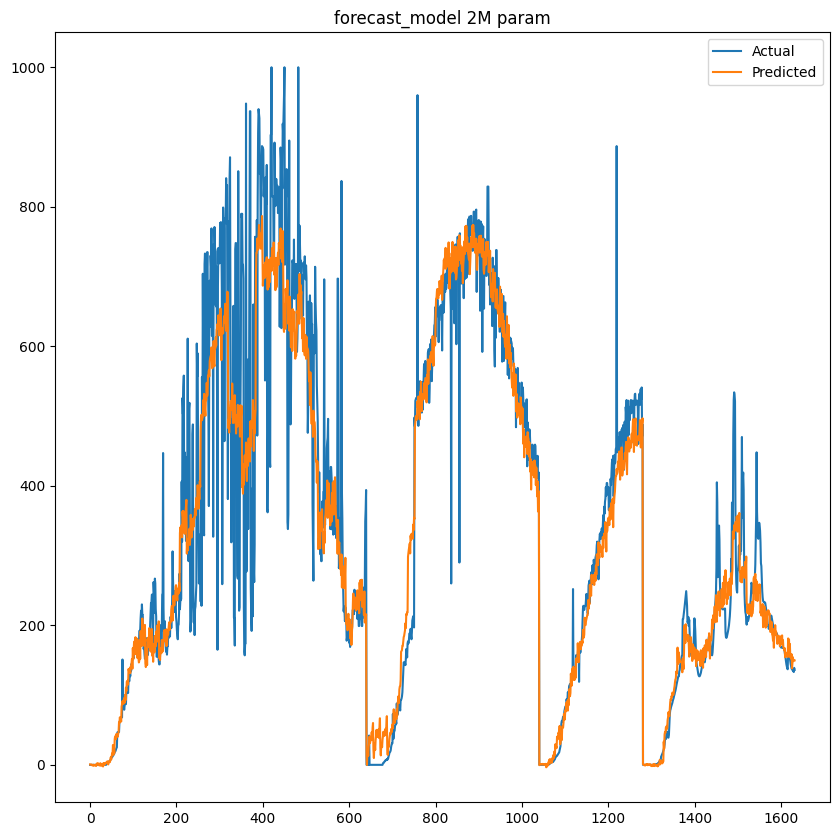

In [ ]:

y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_actual[4000:],label="Actual")
plt.plot(yz[4000:],label="Predicted")
plt.legend()
plt.title("forecast_model 2M param")

"""
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_actual[120+4000:6000],label="Actual")
plt.plot(yz[4000:6000-136],label="Predicted")
plt.legend()
plt.title("model.forecast_7M param")"""